# Automating the Search for Artificial Life with Foundation Models

Automated Search for Artificial Life (ASAL) is an algorithm to automatically find interesting ALife simulations!
Rather than hand designing a particular simulation, just parameterize a set of simulations (e.g. all Lenia simulations) and automatically search over them.


In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

In [20]:
import os, sys, glob, pickle
from functools import partial

import jax
import jax.numpy as jnp
from jax.random import split

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

import util
from create_sim import create_sim, FlattenSimulationParameters, rollout_simulation, rollout_and_embed_simulation


## Supervised Target (Single Target)

To begin, let's search for a Lenia simulation which produces a final state matching a single prompt `"a ufo"`.

Run this command:

In [3]:
! python main_opt.py --seed=0 --save_dir="./data/supervised_0" --sim='lenia' --n_rollout_imgs=1 --prompts="a ufo" --bs=1 --pop_size=16 --n_iters=1000 --sigma=0.1 --coef_prompt=1. --coef_softmax=0. --coef_novelty=0.

Namespace(seed=0, save_dir='./data/supervised_0', sim='lenia', n_rollout_imgs=1, prompts='a ufo', clip_model='clip-vit-base-patch32', coef_prompt=1.0, coef_softmax=0.0, coef_novelty=0.0, bs=1, pop_size=16, n_iters=1000, sigma=0.1)
2024-12-23 23:06:24.204657: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
ParameterReshaper: 3117 parameters detected for optimization.
100%|█████████████████████| 1000/1000 [01:21<00:00, 12.29it/s, best_loss=-0.307]


In [ ]:
data = util.load_pkl("./data/supervised_0", "data") # load optimization data
params, best_loss = util.load_pkl("./data/supervised_0", "best") # load the best parameters found

sim = create_sim('lenia') # create the substrate
sim = FlattenSimulationParameters(sim)
rollout_fn = partial(rollout_and_embed_simulation, sim=sim, clip_model=None, rollout_steps=sim.sim.rollout_steps, n_rollout_imgs=8) # set up the rollout function
rollout_fn = jax.jit(rollout_fn)

rng = jax.random.PRNGKey(0)
rollout_data = rollout_fn(rng, params) # rollout the simulation using this rng seed and simulation parameters

2024-12-23 23:10:02.480896: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


ParameterReshaper: 3117 parameters detected for optimization.


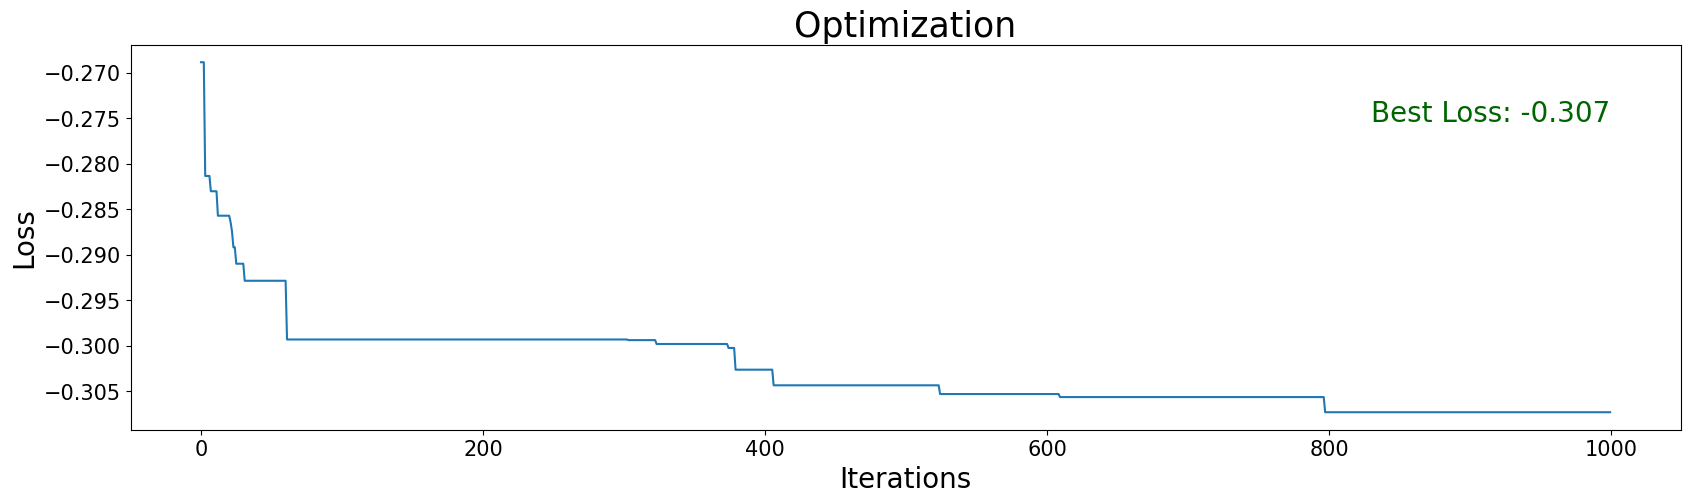

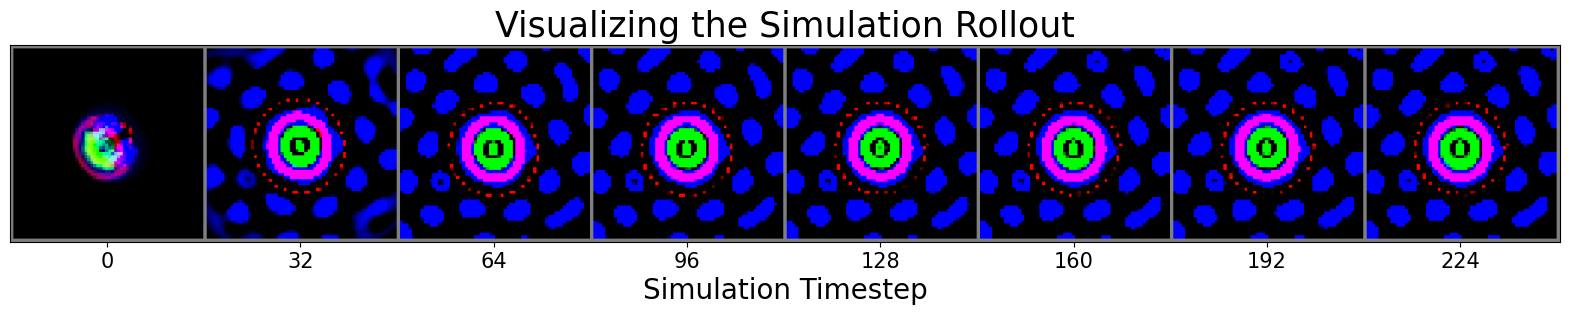

In [5]:
plt.figure(figsize=(20, 5))
plt.plot(data['best_loss'])
plt.xlabel("Iterations", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.title("Optimization", fontsize=25)
plt.text(0.8, 0.8, f"Best Loss: {best_loss:.3f}", color='darkgreen', fontsize=20, transform=plt.gca().transAxes)
plt.show()

plt.figure(figsize=(20, 6))
img = np.array(rollout_data['rgb'])
img = np.pad(img, ((0, 0), (2, 2), (2, 2), (0, 0)), constant_values=0.5)
img = rearrange(img, "T H W D -> H (T W) D")
img = np.pad(img, ((2, 2), (2, 2), (0, 0)), constant_values=0.5)
plt.imshow(img)
plt.xticks(np.arange(0, 8)*228+228//2, np.arange(0, 8)*sim.sim.rollout_steps//8, fontsize=15); plt.yticks([], fontsize=15)
plt.title("Visualizing the Simulation Rollout", fontsize=25)
plt.xlabel("Simulation Timestep", fontsize=20)
plt.show()

## Supervised Target (Temporal Targets)

Now, let's search for a Lenia simulation which produces a trajectory going from `"a single cell"` to `"a diverse ecosystem of cells"`.

Although not required, it sometimes helps to tune the coef_softmax parameter below to incentivize the simulation to find unique images for each prompt rather than one static image satisfying both prompts.

Run this command:

In [49]:
! python main_opt.py --seed=0 --save_dir="./data/supervised_temporal_0" --sim='lenia' --n_rollout_imgs=1 --prompts="a single cell,a diverse ecosystem of cells" --bs=1 --pop_size=16 --n_iters=1000 --sigma=0.1 --coef_prompt=1. --coef_softmax=1. --coef_novelty=0.

/home/akarsh_sakana_ai/miniconda3/envs/nca-alife-jax/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Namespace(seed=0, save_dir='./data/supervised_temporal_0', sim='lenia', n_rollout_imgs=2, prompts='a single cell,a diverse ecosystem of cells', clip_model='clip-vit-base-patch32', coef_prompt=1.0, coef_softmax=1.0, coef_novelty=0.0, bs=1, pop_size=16, n_iters=1000, sigma=0.1)
2024-12-23 20:06:23.141855: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
ParameterReshaper: 3117 parameters detected for optimization.
100%|█████████████████████| 1000/1000 [01:22<00:00, 12.08it/s, best_loss=-0.156]


In [50]:
data = util.load_pkl("./data/supervised_temporal_0", "data") # load optimization data
params, best_loss = util.load_pkl("./data/supervised_temporal_0", "best") # load the best parameters found

sim = create_sim('lenia') # create the substrate
sim = FlattenSimulationParameters(sim)
rollout_fn = partial(rollout_and_embed_simulation, sim=sim, clip_model=None, rollout_steps=sim.sim.rollout_steps, n_rollout_imgs=8) # set up the rollout function
rollout_fn = jax.jit(rollout_fn)

rng = jax.random.PRNGKey(0)
rollout_data = rollout_fn(rng, params) # rollout the simulation using this rng seed and simulation parameters

ParameterReshaper: 3117 parameters detected for optimization.


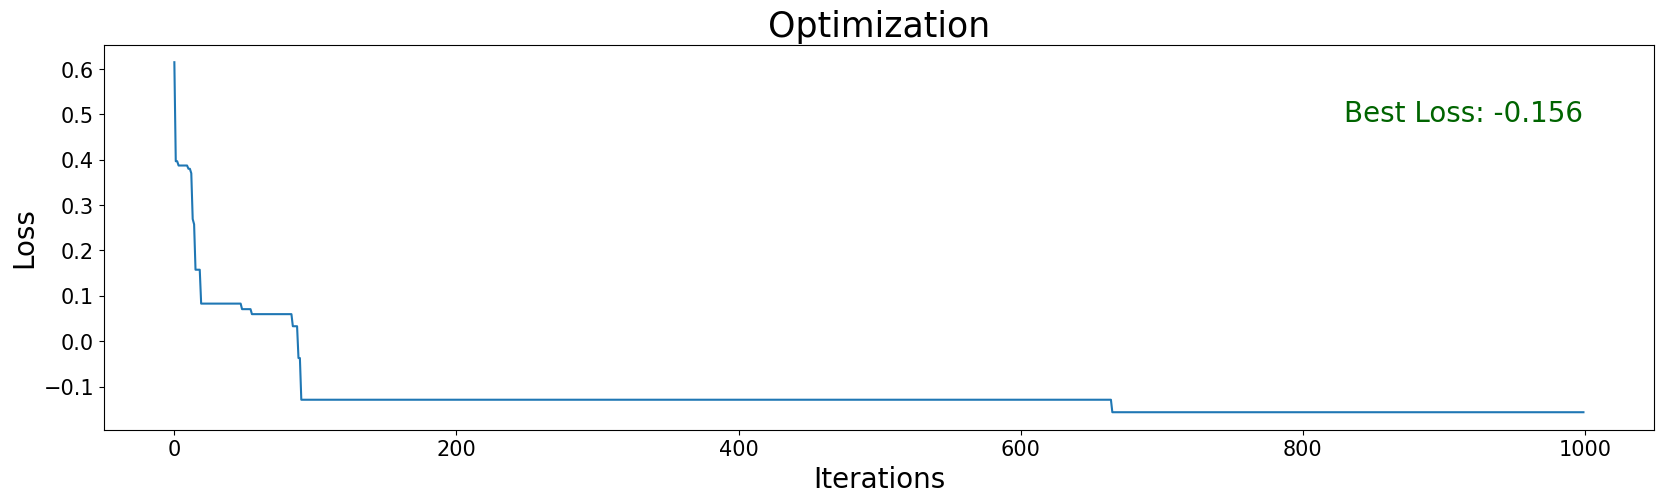

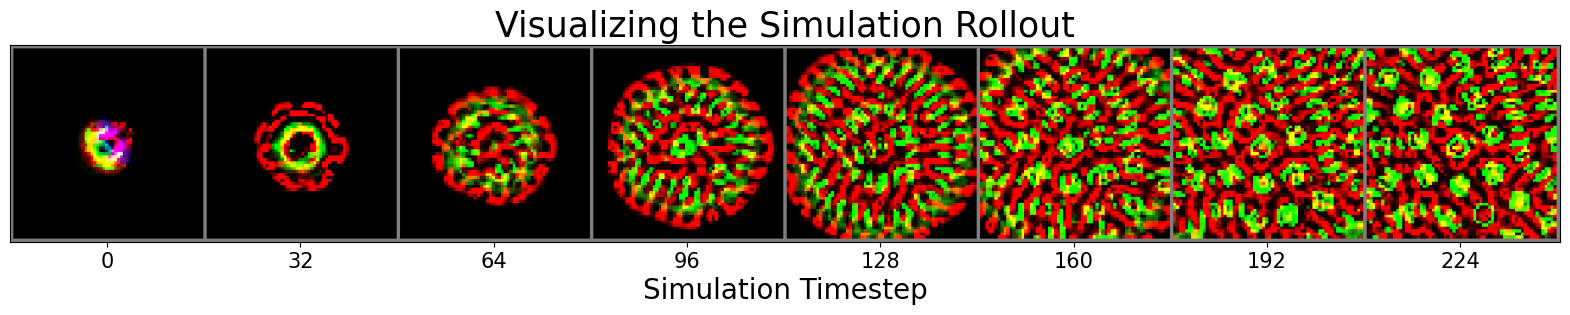

In [51]:
plt.figure(figsize=(20, 5))
plt.plot(data['best_loss'])
plt.xlabel("Iterations", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.title("Optimization", fontsize=25)
plt.text(0.8, 0.8, f"Best Loss: {best_loss:.3f}", color='darkgreen', fontsize=20, transform=plt.gca().transAxes)
plt.show()

plt.figure(figsize=(20, 6))
img = np.array(rollout_data['rgb'])
img = np.pad(img, ((0, 0), (2, 2), (2, 2), (0, 0)), constant_values=0.5)
img = rearrange(img, "T H W D -> H (T W) D")
img = np.pad(img, ((2, 2), (2, 2), (0, 0)), constant_values=0.5)
plt.imshow(img)
plt.xticks(np.arange(0, 8)*228+228//2, np.arange(0, 8)*sim.sim.rollout_steps//8, fontsize=15); plt.yticks([], fontsize=15)
plt.title("Visualizing the Simulation Rollout", fontsize=25)
plt.xlabel("Simulation Timestep", fontsize=20)
plt.show()

## Open-Endedness

Great! Now let's discover a Lenia simulation which is open-ended, meaning it generates novelty in time.

Run this command:

In [6]:
! python main_opt.py --seed=0 --save_dir="./data/oe_0" --sim='lenia' --n_rollout_imgs=128 --prompts="" --bs=1 --pop_size=16 --n_iters=1000 --sigma=0.1 --coef_prompt=0. --coef_softmax=0. --coef_novelty=1.

/home/akarsh_sakana_ai/.conda/envs/asal_test/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Namespace(seed=0, save_dir='./data/oe_0', sim='lenia', n_rollout_imgs=128, prompts='', clip_model='clip-vit-base-patch32', coef_prompt=0.0, coef_softmax=0.0, coef_novelty=1.0, bs=1, pop_size=16, n_iters=1000, sigma=0.1)
2024-12-23 23:13:10.463791: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
ParameterReshaper: 3117 parameters detected for optimization.
  0%|                                                  | 0/1000 [00:00<?, ?it/s]Could not load symbol cuFuncGetName. Error: /lib/x86_64-linux-gnu/libcuda.so.1: undefined symbol: cuFuncGetName
2024-12-23 23:13:33.827021: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv

In [8]:
data = util.load_pkl("./data/oe_0", "data") # load optimization data
params, best_loss = util.load_pkl("./data/oe_0", "best") # load the best parameters found

sim = create_sim('lenia') # create the substrate
sim = FlattenSimulationParameters(sim)
rollout_fn = partial(rollout_and_embed_simulation, sim=sim, clip_model=None, rollout_steps=sim.sim.rollout_steps, n_rollout_imgs=8) # set up the rollout function
rollout_fn = jax.jit(rollout_fn)

rng = jax.random.PRNGKey(0)
rollout_data = rollout_fn(rng, params) # rollout the simulation using this rng seed and simulation parameters

ParameterReshaper: 3117 parameters detected for optimization.


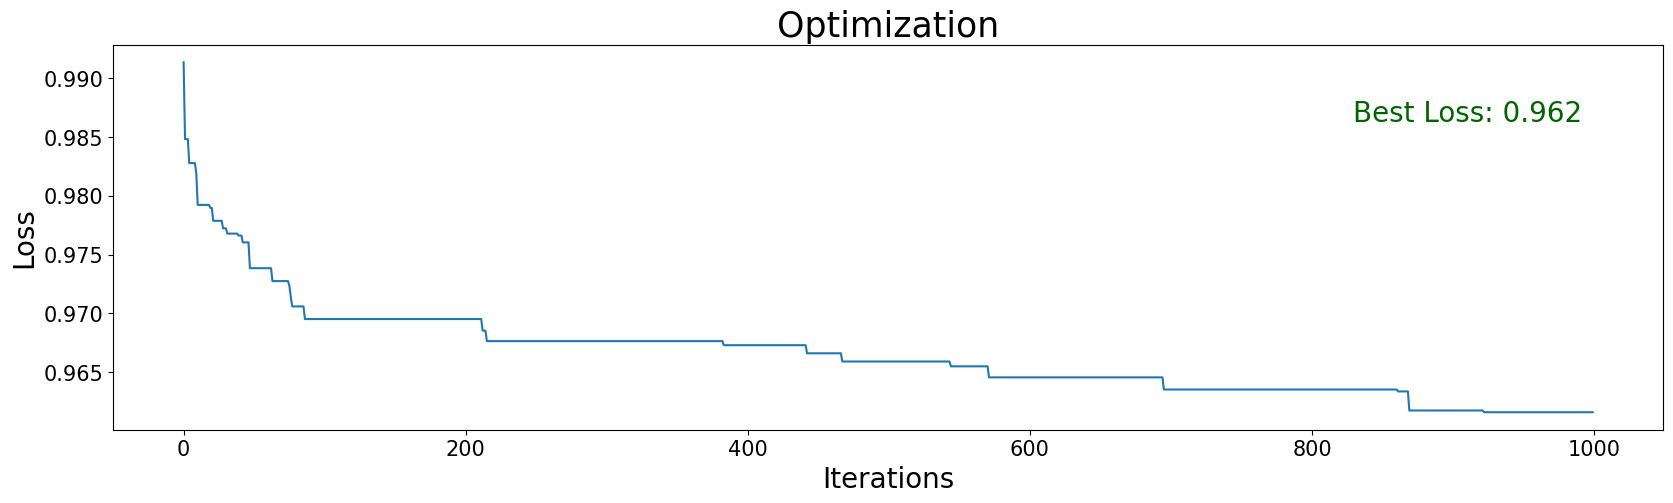

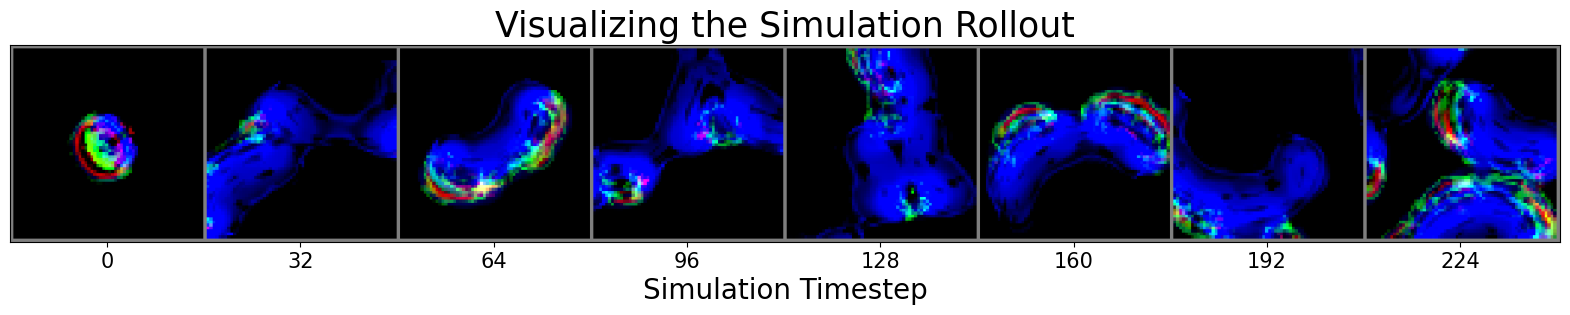

In [9]:
plt.figure(figsize=(20, 5))
plt.plot(data['best_loss'])
plt.xlabel("Iterations", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.title("Optimization", fontsize=25)
plt.text(0.8, 0.8, f"Best Loss: {best_loss:.3f}", color='darkgreen', fontsize=20, transform=plt.gca().transAxes)
plt.show()

plt.figure(figsize=(20, 6))
img = np.array(rollout_data['rgb'])
img = np.pad(img, ((0, 0), (2, 2), (2, 2), (0, 0)), constant_values=0.5)
img = rearrange(img, "T H W D -> H (T W) D")
img = np.pad(img, ((2, 2), (2, 2), (0, 0)), constant_values=0.5)
plt.imshow(img)
plt.xticks(np.arange(0, 8)*228+228//2, np.arange(0, 8)*sim.sim.rollout_steps//8, fontsize=15); plt.yticks([], fontsize=15)
plt.title("Visualizing the Simulation Rollout", fontsize=25)
plt.xlabel("Simulation Timestep", fontsize=20)
plt.show()

## Illumination

Run this command in the terminal:

In [11]:
! python main_illuminate.py --seed=0 --save_dir="./data/illuminate_0" --sim='lenia' --k_nbrs=2 --bs=32 --pop_size=256 --n_iters=10000 --sigma1=0.1 --sigma2=0.

2024-12-23 23:38:34.805492: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
ParameterReshaper: 3117 parameters detected for optimization.
  0%|                                                 | 0/10000 [00:00<?, ?it/s](288, 512)
Could not load symbol cuFuncGetName. Error: /lib/x86_64-linux-gnu/libcuda.so.1: undefined symbol: cuFuncGetName
 54%|█████████████▉            | 5376/10000 [10:44<09:14,  8.35it/s, loss=0.876]
Traceback (most recent call last):
  File "/home/akarsh_sakana_ai/asal/main_illuminate.py", line 138, in <module>
    main(parse_args())
  File "/home/akarsh_sakana_ai/asal/main_illuminate.py", line 115, in main
    pop, di = do_iter(pop, rng)

In [ ]:
data = util.load_pkl("./data/illuminate_0", "data") # load optimization data
pop = util.load_pkl("./data/illuminate_0", "pop") # load the best parameters found
params = pop['params']

sim = create_sim('lenia') # create the substrate
sim = FlattenSimulationParameters(sim)
rollout_fn = partial(rollout_and_embed_simulation, sim=sim, clip_model=None, rollout_steps=sim.sim.rollout_steps, n_rollout_imgs='final') # set up the rollout function
rollout_fn = jax.jit(rollout_fn)

rng = jax.random.PRNGKey(0)
rollout_data = jax.vmap(rollout_fn, in_axes=(None, 0))(rng, params) # rollout the simulation using this rng seed and simulation parameters

ParameterReshaper: 3117 parameters detected for optimization.


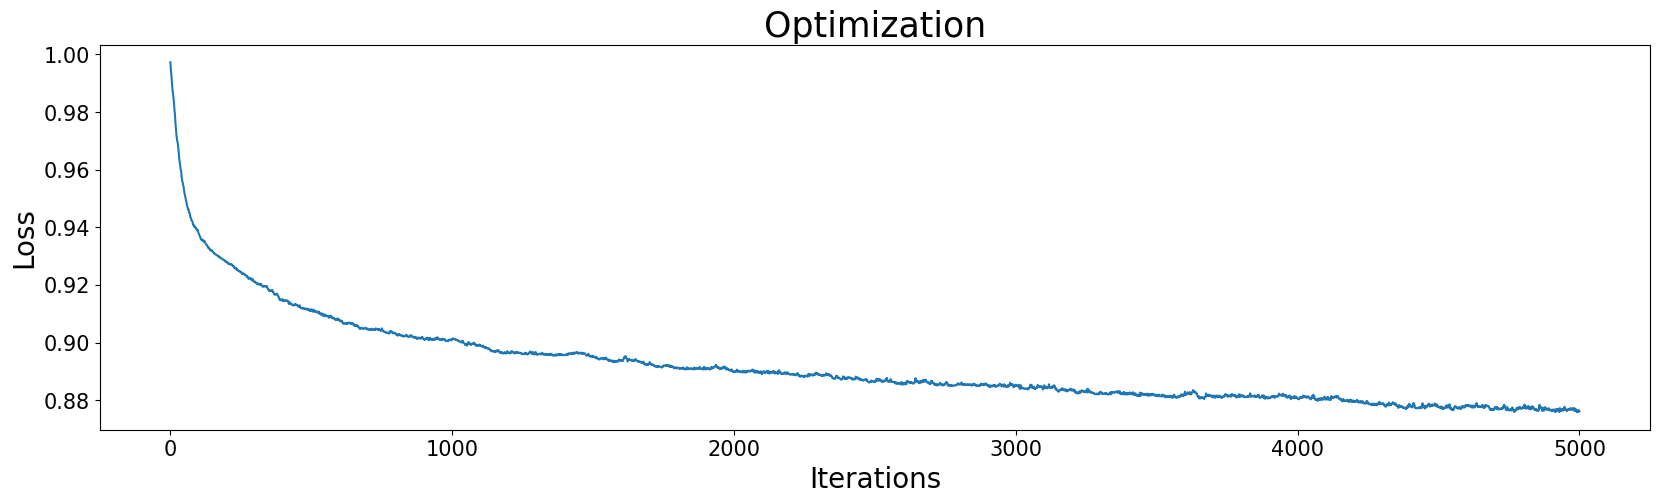

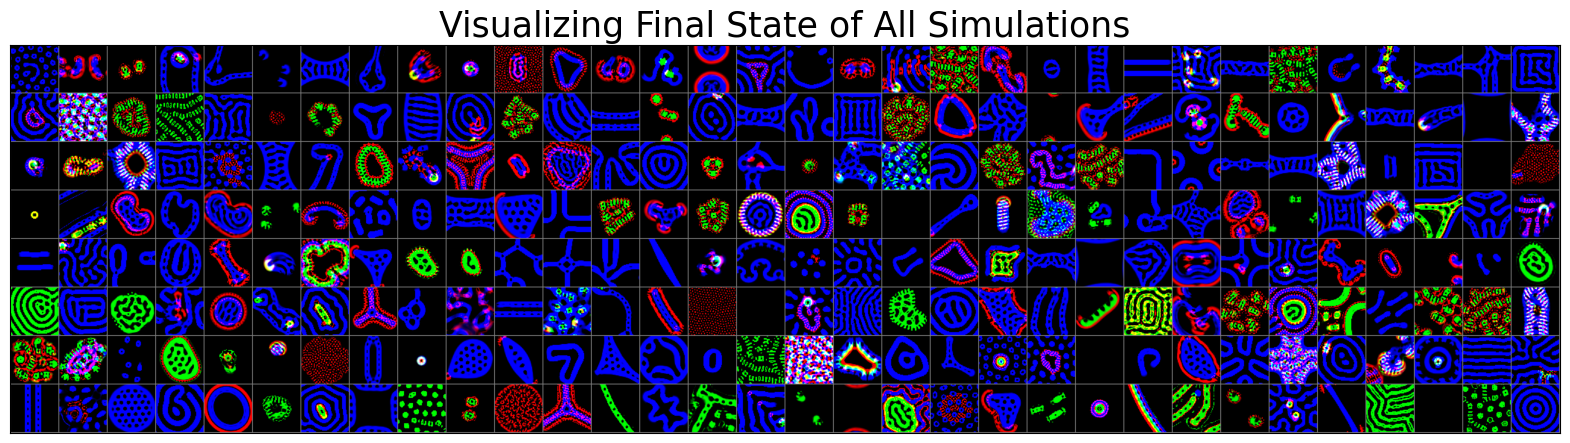

In [18]:
plt.figure(figsize=(20, 5))
plt.plot(data['loss'])
plt.xlabel("Iterations", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.title("Optimization", fontsize=25)
# plt.text(0.8, 0.8, f"Best Loss: {best_loss:.3f}", color='darkgreen', fontsize=20, transform=plt.gca().transAxes)
plt.show()


plt.figure(figsize=(20, 6))
img = np.array(rollout_data['rgb'])
img = np.pad(img, ((0, 0), (2, 2), (2, 2), (0, 0)), constant_values=0.5)
img = rearrange(img, "(R C) H W D -> (R H) (C W) D", R=8)
img = np.pad(img, ((2, 2), (2, 2), (0, 0)), constant_values=0.5)
plt.imshow(img)
plt.xticks([], fontsize=15); plt.yticks([], fontsize=15)
plt.title("Visualizing Final State of All Simulations", fontsize=25)
plt.show()

## Continue!

Above, we only showed results on Lenia because it runs the fastest, but feel free to run on other substrates as well!
We have implemented the following substrates already:
- [Lenia](https://en.wikipedia.org/wiki/Lenia)
- [Boids](https://en.wikipedia.org/wiki/Boids)
- [Particle Life](https://www.youtube.com/watch?v=scvuli-zcRc)
- Particle Life++
  - (Particle Life with changing color dynamics)
- [Particle Lenia](https://google-research.github.io/self-organising-systems/particle-lenia/)
- Discrete Neural Cellular Automata
- [Continuous Neural Cellular Automata](https://distill.pub/2020/growing-ca/)
- [Game of Life/Life-Like Cellular Automata](https://en.wikipedia.org/wiki/Life-like_cellular_automaton)


The following block visualizes random simulation parameters in each of these substrates.

Feel free to find supervised target simulations in Boids, illuminate all Discrete NCAs, find open-ended Particle Life++ simulations, or any combination you want!

Note that Game of Life will not work with the above scripts, because it is a discrete search space.
For sweeping Game of Life, check out the `main_sweep_gol.py` script.

Particle Life++ has lots of potential and is an extremely untapped substrate so far, so experimenting with that would be very cool, although optimization is hard in that, due to how chaotic it is.

If you get bored, it would be amazing to apply ASAL to newer substrates like [ALIEN](https://www.youtube.com/watch?v=qwbMGPkoJmg) and [JaxLife](https://github.com/luchris429/jaxlife)!


ParameterReshaper: 3117 parameters detected for optimization.


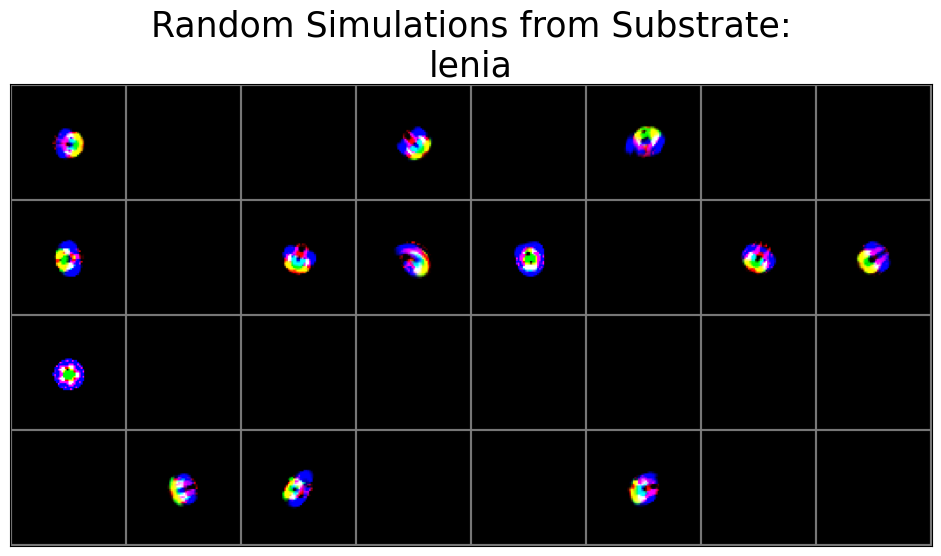

ParameterReshaper: 193 parameters detected for optimization.


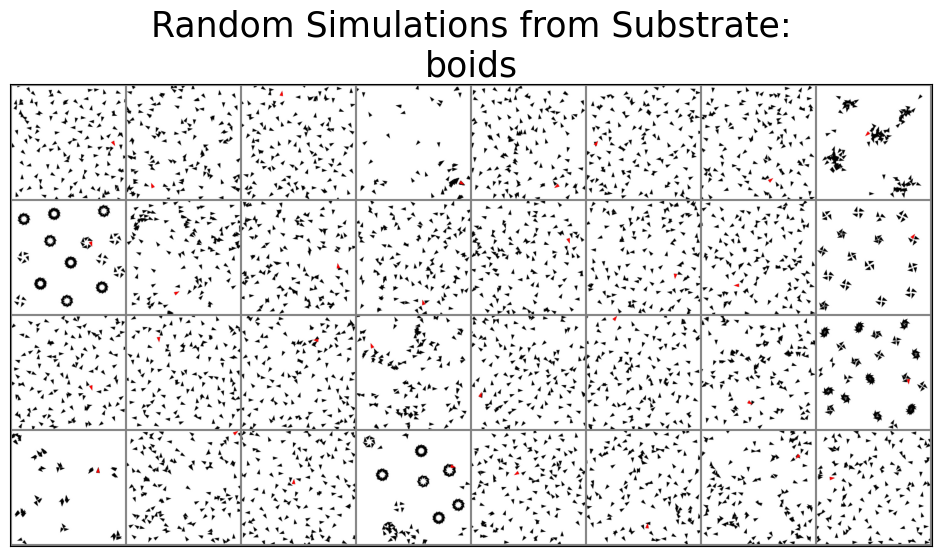

ParameterReshaper: 42 parameters detected for optimization.


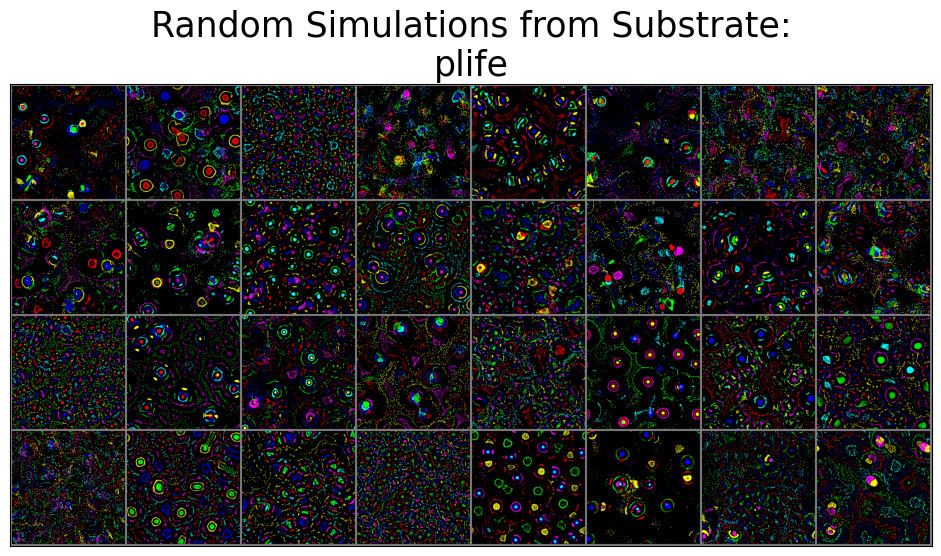

ParameterReshaper: 311 parameters detected for optimization.


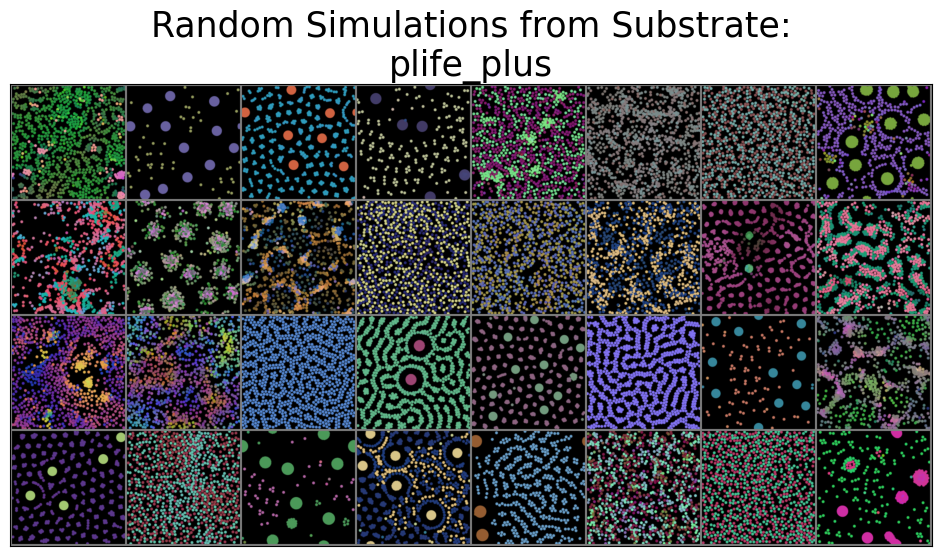

ParameterReshaper: 6 parameters detected for optimization.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


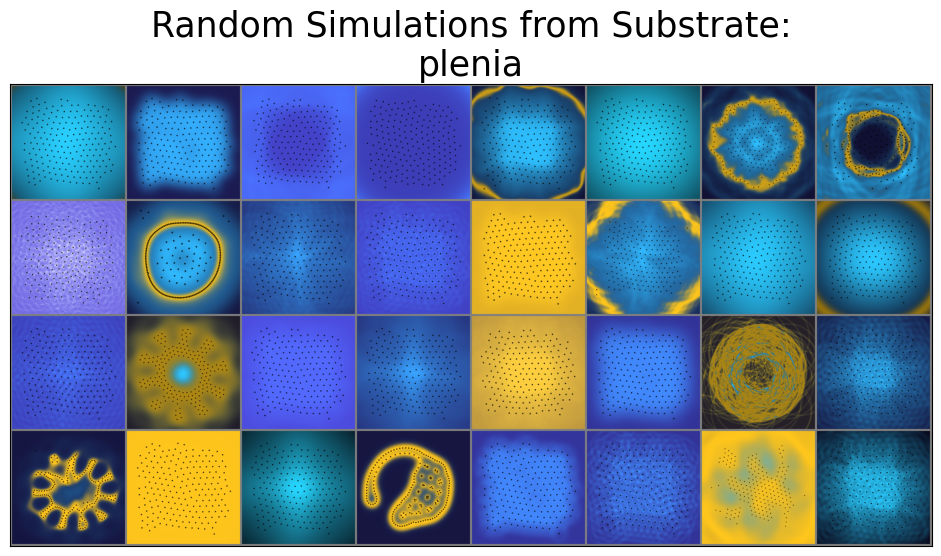

ParameterReshaper: 588 parameters detected for optimization.


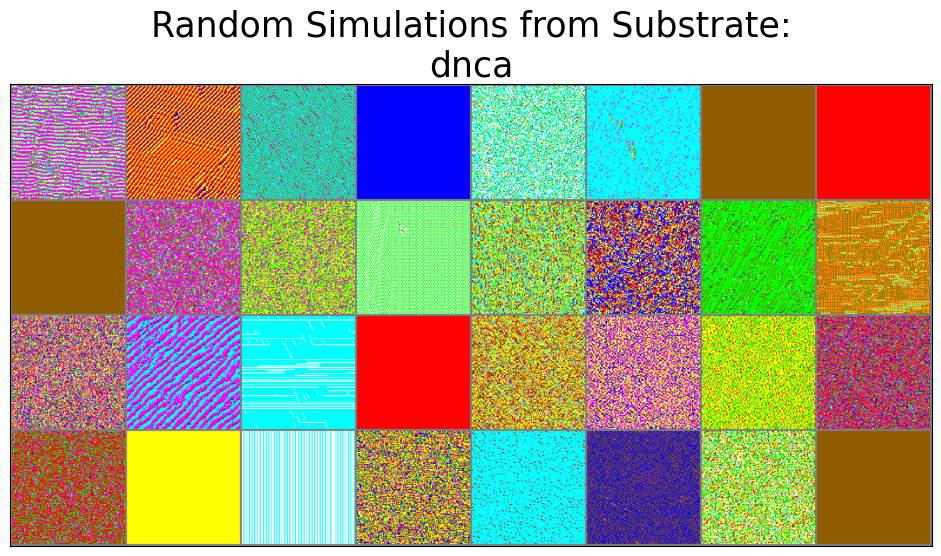

ParameterReshaper: 209 parameters detected for optimization.


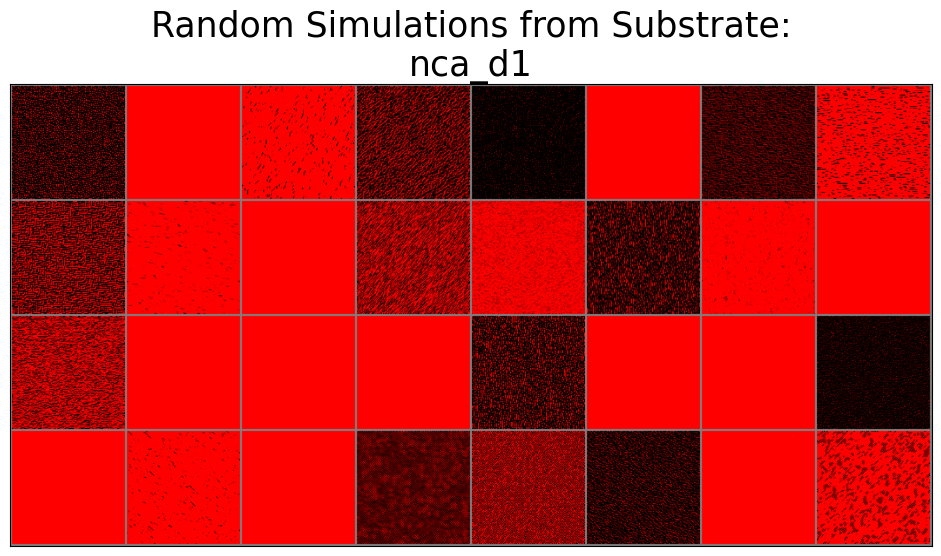

ParameterReshaper: 315 parameters detected for optimization.


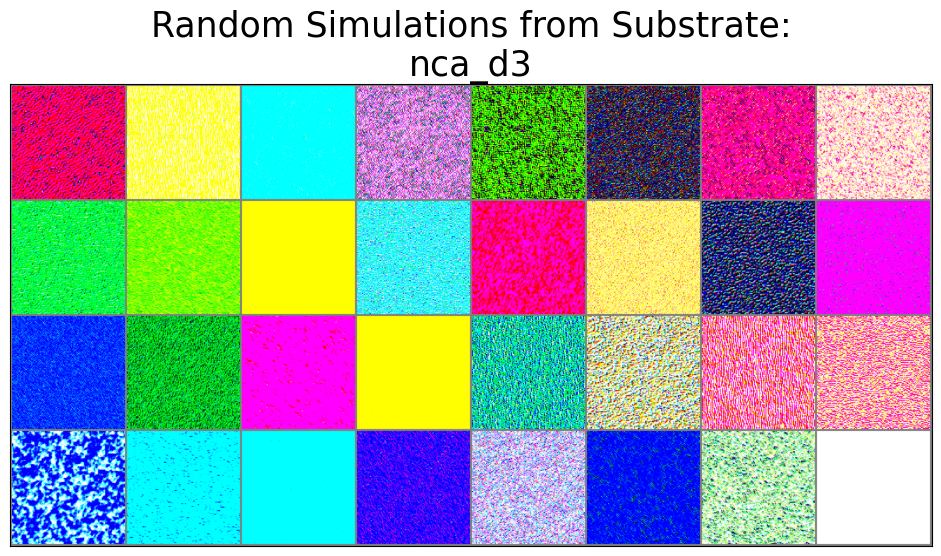

ParameterReshaper: 1 parameters detected for optimization.


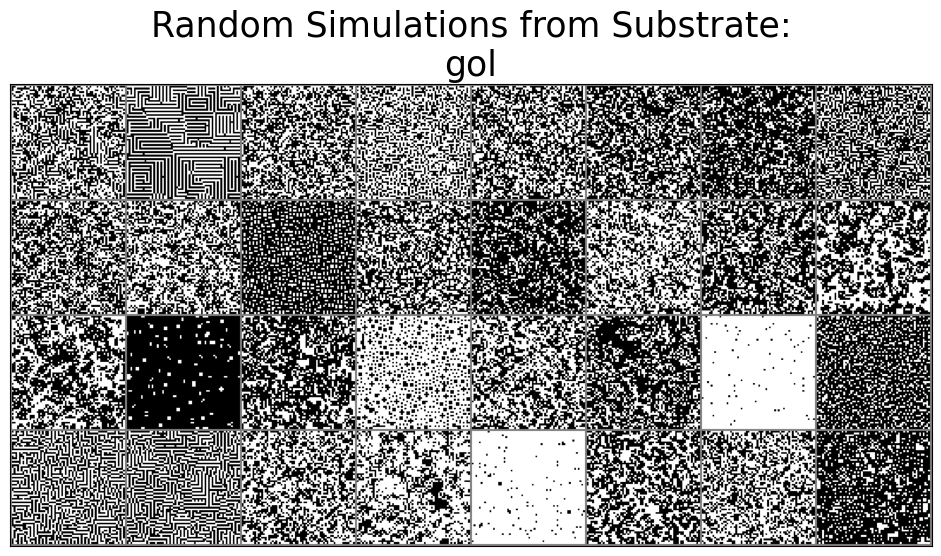

In [35]:
for sim_name in ['lenia', 'boids', 'plife', 'plife_plus', 'plenia', 'dnca', 'nca_d1', 'nca_d3', 'gol']: # loop over substrates
    sim = create_sim(sim_name) # create the substrate
    sim = FlattenSimulationParameters(sim)

    rollout_fn = partial(rollout_and_embed_simulation, sim=sim, clip_model=None, rollout_steps=sim.sim.rollout_steps, n_rollout_imgs='final') # set up the rollout function
    rollout_fn = jax.jit(rollout_fn)

    rng = jax.random.PRNGKey(0)
    params = sim.default_params(rng)
    params = jax.vmap(sim.default_params)(split(rng, 32)) # sample some random simulation parameters

    rollout_data = jax.vmap(rollout_fn, in_axes=(None, 0))(rng, params) # rollout the simulation using this rng seed and simulation parameters

    img = np.array(rollout_data['rgb'])
    img = np.pad(img, ((0, 0), (2, 2), (2, 2), (0, 0)), constant_values=0.5)
    img = rearrange(img, "(R C) H W D -> (R H) (C W) D", R=4)
    img = np.pad(img, ((2, 2), (2, 2), (0, 0)), constant_values=0.5)
    plt.figure(figsize=(20, 6))
    plt.imshow(img)
    plt.xticks([], fontsize=15); plt.yticks([], fontsize=15)
    plt.title(f"Random Simulations from Substrate:\n{sim_name}", fontsize=25)
    plt.show()